In [4]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060524,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062686,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063767,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062145,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061065,47894400
...,...,...,...,...,...,...,...
9401,2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700
9402,2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400
9403,2023-07-06,337.299988,342.989990,335.500000,341.269989,341.269989,28161200
9404,2023-07-07,339.320007,341.790009,337.000000,337.220001,337.220001,21185300


In [9]:
df = df[['Date','Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9401,2023-07-03,337.989990
9402,2023-07-05,338.149994
9403,2023-07-06,341.269989
9404,2023-07-07,337.220001


In [10]:
import datetime

def str_to_datetime(s):
    s = s.split('-')
    year,month,day = int(s[0]),int(s[1]),int(s[2])
    return datetime.datetime(year = year, month = month,day = day)

df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9401   2023-07-03
9402   2023-07-05
9403   2023-07-06
9404   2023-07-07
9405   2023-07-10
Name: Date, Length: 9406, dtype: datetime64[ns]

In [11]:
df.index = df.pop('Date')

In [12]:
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-07-03,337.989990
2023-07-05,338.149994
2023-07-06,341.269989


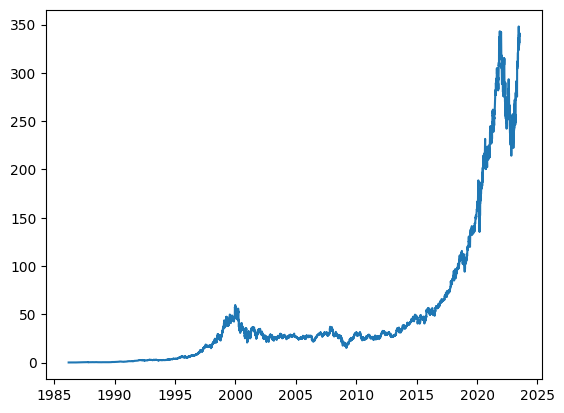

In [13]:
import matplotlib.pyplot as plt
plt.plot(df.index,df['Close'])

In [48]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2022-07-10', 
                                '2023-07-10', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-07-10,262.850006,266.209991,268.399994,267.660004
1,2022-07-12,268.399994,267.660004,264.510010,253.669998
2,2022-07-13,267.660004,264.510010,253.669998,252.720001
3,2022-07-14,264.510010,253.669998,252.720001,254.080002
4,2022-07-15,253.669998,252.720001,254.080002,256.720001
...,...,...,...,...,...
246,2023-07-03,335.850006,335.049988,340.540009,337.989990
247,2023-07-05,335.049988,340.540009,337.989990,338.149994
248,2023-07-06,340.540009,337.989990,338.149994,341.269989
249,2023-07-07,337.989990,338.149994,341.269989,337.220001


In [64]:
def windowed_df_to_date_x_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:,0]
    
    middle_matrix = df_as_np[:,1:-1]
    x = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
    y = df_as_np[:,-1]
    
    return dates,x.astype(np.float32),y.astype(np.float32)

dates, x,y = windowed_df_to_date_x_y(windowed_df)
dates.shape,x.shape,y.shape

((251,), (251, 3, 1), (251,))

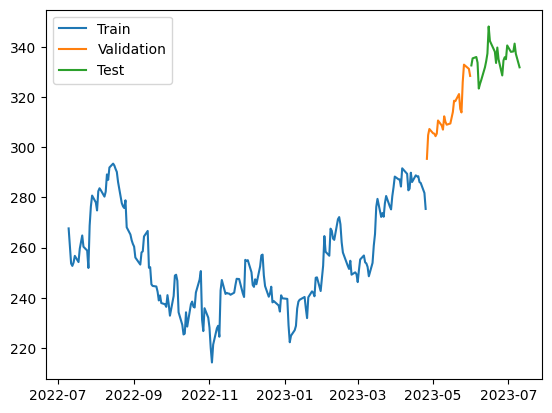

In [63]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]

dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 96ms/step - loss: 65533.6289 - mean_absolute_error: 255.2816 - val_loss: 97774.4062 - val_mean_absolute_error: 312.5599
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 65252.8359 - mean_absolute_error: 254.7307 - val_loss: 97444.8906 - val_mean_absolute_error: 312.0323
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 64995.6484 - mean_absolute_error: 254.2255 - val_loss: 97146.5938 - val_mean_absolute_error: 311.5539
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 64740.9414 - mean_absolute_error: 253.7229 - val_loss: 96798.8281 - val_mean_absolute_error: 310.9952
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 64415.0586 - mean_absolute_error: 253.0817 - val_loss: 96329.8672 - val_mean_absolute_error: 310.2404
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 64030.3711 - mean_absolute_error: 252.3186 - val_loss: 95824.25

Epoch 49/100
7/7 [==============================] - 0s 9ms/step - loss: 352.6791 - mean_absolute_error: 15.6720 - val_loss: 3291.1184 - val_mean_absolute_error: 56.6806
Epoch 50/100
7/7 [==============================] - 0s 9ms/step - loss: 350.4120 - mean_absolute_error: 15.4607 - val_loss: 3423.8899 - val_mean_absolute_error: 57.8583
Epoch 51/100
7/7 [==============================] - 0s 8ms/step - loss: 342.3982 - mean_absolute_error: 15.0526 - val_loss: 3317.8481 - val_mean_absolute_error: 56.9352
Epoch 52/100
7/7 [==============================] - 0s 8ms/step - loss: 332.0251 - mean_absolute_error: 15.0141 - val_loss: 3255.7236 - val_mean_absolute_error: 56.3880
Epoch 53/100
7/7 [==============================] - 0s 8ms/step - loss: 328.6669 - mean_absolute_error: 15.0527 - val_loss: 3235.1648 - val_mean_absolute_error: 56.2170
Epoch 54/100
7/7 [==============================] - 0s 8ms/step - loss: 325.9950 - mean_absolute_error: 14.7016 - val_loss: 3238.0513 - val_mean_absolute_e

Epoch 98/100
7/7 [==============================] - 0s 8ms/step - loss: 45.1529 - mean_absolute_error: 5.4968 - val_loss: 792.5170 - val_mean_absolute_error: 27.2382
Epoch 99/100
7/7 [==============================] - 0s 8ms/step - loss: 43.5986 - mean_absolute_error: 5.3839 - val_loss: 820.3656 - val_mean_absolute_error: 27.7918
Epoch 100/100
7/7 [==============================] - 0s 8ms/step - loss: 43.7996 - mean_absolute_error: 5.1696 - val_loss: 801.4783 - val_mean_absolute_error: 27.4464


7/7 [==============================] - 0s 2ms/step


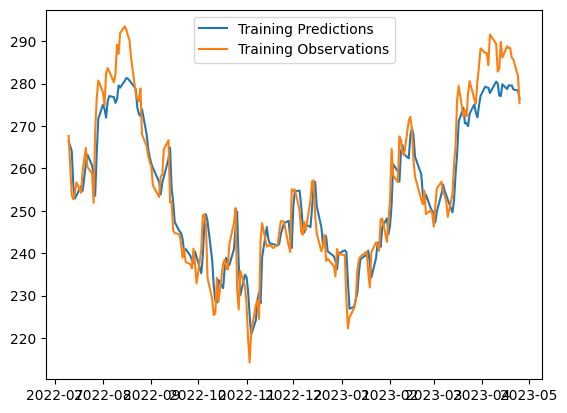

In [58]:
 train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


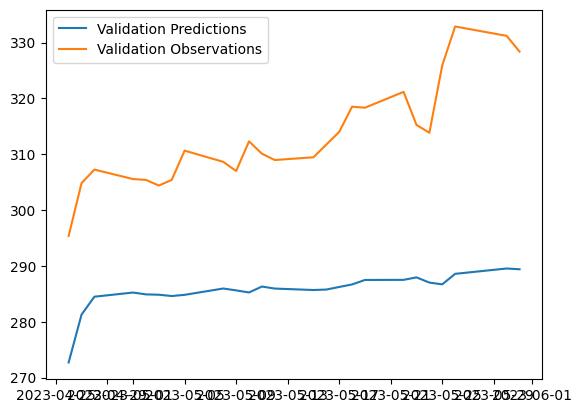

In [59]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 26ms/step


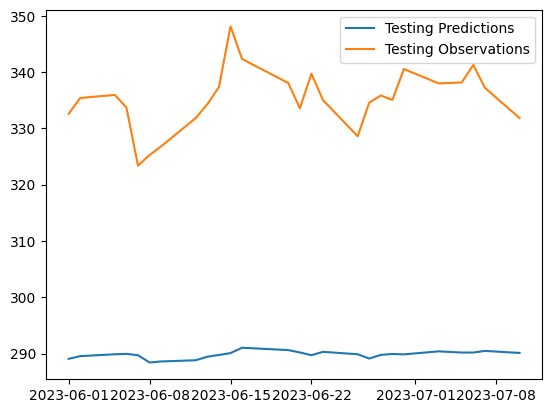

In [60]:
test_predictions = model.predict(x_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

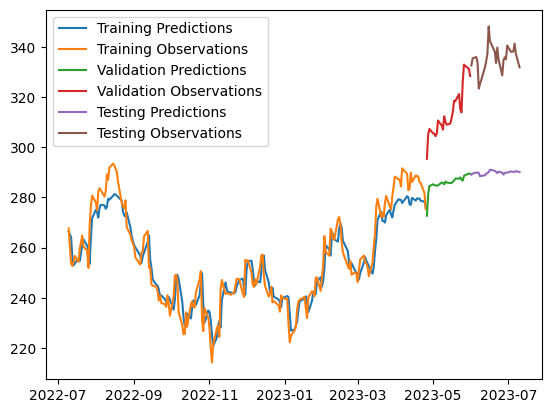

In [61]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])